In [2]:
import matplotlib
matplotlib.use("Agg")

In [3]:
import sys
sys.path.append("/content/drive/MyDrive/Final_project/data/models")

In [4]:
from google.colab import files
files.upload()

Saving helpers.py to helpers.py


{'helpers.py': b'# import the necessary packages\nfrom tensorflow.keras.datasets import mnist\nimport numpy as np\n\ndef load_az_dataset(datasetPath):\n\t# initialize the list of data and labels\n\tdata = []\n\tlabels = []\n\n\t# loop over the rows of the A-Z handwritten digit dataset\n\tfor row in open(datasetPath):\n\t\t# parse the label and image from the row\n\t\trow = row.split(",")\n\t\tlabel = int(row[0])\n\t\timage = np.array([int(x) for x in row[1:]], dtype="uint8")\n\n\t\t# images are represented as single channel (grayscale) images\n\t\t# that are 28x28=784 pixels -- we need to take this flattened\n\t\t# 784-d list of numbers and repshape them into a 28x28 matrix\n\t\timage = image.reshape((28, 28))\n\n\t\t# update the list of data and labels\n\t\tdata.append(image)\n\t\tlabels.append(label)\n\n\t# convert the data and labels to NumPy arrays\n\tdata = np.array(data, dtype="float32")\n\tlabels = np.array(labels, dtype="int")\n\n\t# return a 2-tuple of the A-Z data and labels\

In [5]:
from google.colab import files
files.upload()

Saving resnet.py to resnet.py


{'resnet.py': b'# import the necessary packages\nfrom tensorflow.keras.layers import BatchNormalization\nfrom tensorflow.keras.layers import Conv2D\nfrom tensorflow.keras.layers import AveragePooling2D\nfrom tensorflow.keras.layers import MaxPooling2D\nfrom tensorflow.keras.layers import ZeroPadding2D\nfrom tensorflow.keras.layers import Activation\nfrom tensorflow.keras.layers import Dense\nfrom tensorflow.keras.layers import Flatten\nfrom tensorflow.keras.layers import Input\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras.layers import add\nfrom tensorflow.keras.regularizers import l2\nfrom tensorflow.keras import backend as K\n\nclass ResNet:\n\t@staticmethod\n\tdef residual_module(data, K, stride, chanDim, red=False,\n\t\treg=0.0001, bnEps=2e-5, bnMom=0.9):\n\t\t# the shortcut branch of the ResNet module should be\n\t\t# initialize as the input (identity) data\n\t\tshortcut = data\n\n\t\t# the first block of the ResNet module are the 1x1 CONVs\n\t\tbn1 = BatchNorm

In [6]:
from resnet import ResNet
from helpers import load_mnist_dataset
from helpers import load_az_dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

In [7]:
paths={"az":"/content/drive/MyDrive/Final_project/a_z_handwritten_data.csv","model":"Handwriting.model"}

In [8]:
EPOCHS = 10
INIT_LR = 1e-1
BS = 16

In [9]:
print("[INFO] loading datasets...")
(azData, azLabels) = load_az_dataset(paths["az"])
(digitsData, digitsLabels) = load_mnist_dataset()

[INFO] loading datasets...
11493376/11490434 [==============================] - 0s 0us/step


In [10]:
azLabels += 10

data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])

In [11]:
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

In [12]:
data = np.expand_dims(data, axis=-1)
data /= 255.0

In [13]:
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)

In [14]:
classTotals = labels.sum(axis=0)
classWeight = {}

In [15]:
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

In [16]:
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.20, stratify=labels, random_state=42)

In [17]:
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	fill_mode="nearest")

In [18]:
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
	(64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])


[INFO] compiling model...


In [19]:
print("[INFO] training network...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS,
	class_weight=classWeight,
	verbose=1)

[INFO] training network...
Epoch 1/10
22122/22122 [==============================] - 464s 19ms/step - loss: 3.4625 - accuracy: 0.7836 - val_loss: 0.5270 - val_accuracy: 0.9120
Epoch 2/10
22122/22122 [==============================] - 423s 19ms/step - loss: 1.3525 - accuracy: 0.9006 - val_loss: 0.5117 - val_accuracy: 0.9188
Epoch 3/10
22122/22122 [==============================] - 419s 19ms/step - loss: 1.2688 - accuracy: 0.9068 - val_loss: 0.5214 - val_accuracy: 0.9117
Epoch 4/10
22122/22122 [==============================] - 418s 19ms/step - loss: 1.2103 - accuracy: 0.9105 - val_loss: 0.5328 - val_accuracy: 0.9034
Epoch 5/10
22122/22122 [==============================] - 416s 19ms/step - loss: 1.1911 - accuracy: 0.9117 - val_loss: 0.5236 - val_accuracy: 0.9064
Epoch 6/10
22122/22122 [==============================] - 417s 19ms/step - loss: 1.1728 - accuracy: 0.9121 - val_loss: 0.5240 - val_accuracy: 0.9080
Epoch 7/10
22122/22122 [==============================] - 416s 19ms/step - loss

In [20]:
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.18      0.85      0.30      1381
           1       0.97      0.98      0.97      1575
           2       0.90      0.94      0.92      1398
           3       0.95      0.99      0.97      1428
           4       0.87      0.96      0.91      1365
           5       0.63      0.90      0.74      1263
           6       0.93      0.97      0.95      1375
           7       0.95      0.99      0.97      1459
           8       0.86      0.98      0.91      1365
           9       0.95      0.99      0.97      1392
           A       0.99      0.99      0.99      2774
           B       0.98      0.98      0.98      1734
           C       0.99      0.97      0.98      4682
           D       0.92      0.96      0.94      2027
           E       0.99      0.98      0.98      2288
           F       0.93      0.99      0.96       232
           G       0.96      0.94      0.95      115

In [21]:
print("[INFO] serializing network...")
model.save(paths["model"], save_format="h5")

[INFO] serializing network...


In [23]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot1")

In [24]:
images = []

# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
	# classify the character
	probs = model.predict(testX[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]


In [27]:
image = (testX[i] * 255).astype("uint8")
color = (0, 255, 0)

	# otherwise, the class label prediction is incorrect
if prediction[0] != np.argmax(testY[i]):
	color = (0, 0, 255)

In [28]:
image = cv2.merge([image] * 3)
image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [29]:
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
	# classify the character
	probs = model.predict(testX[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]

	# extract the image from the test data and initialize the text
	# label color as green (correct)
	image = (testX[i] * 255).astype("uint8")
	color = (0, 255, 0)

	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(testY[i]):
		color = (0, 0, 255)

	# merge the channels into one image, resize the image from 32x32
	# to 96x96 so we can better see it and then draw the predicted
	# label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)

	# add the image to our list of output images
	images.append(image)

In [31]:
from google.colab.patches import cv2_imshow

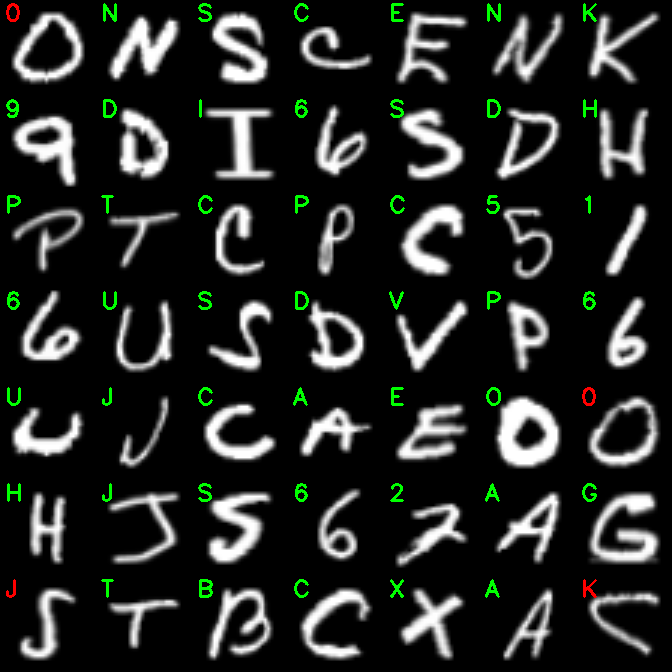

-1

In [33]:
montage = build_montages(images, (96, 96), (7, 7))[0]

# show the output montage
cv2_imshow(montage)
cv2.waitKey(0)